In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import h5py
import math
import scipy
import torch
import pdb
import utils
import torch.nn as nn
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models

In [2]:
os.sys.path

['',
 '/home/ubuntu/src/cntk/bindings/python',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython']

In [3]:
home = os.path.expanduser("~")
dataRoot = os.path.join(home, "CS230", "CheXpert-v1.0-small")
os.listdir(dataRoot)

['valid',
 'valid_final.csv',
 'train_final.csv',
 'train_final_V2.csv',
 'train_1_example.csv',
 'train',
 'valid.csv',
 'test_final.csv',
 'train.csv',
 'valid_1_example.csv']

In [4]:
"""Import and Preprocess Data"""

'Import and Preprocess Data'

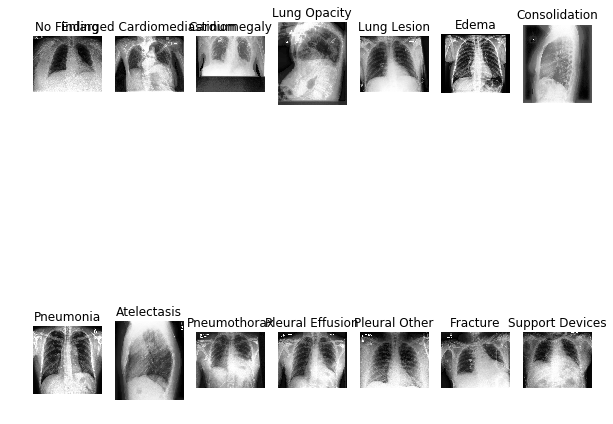

In [5]:
import cv2

TASKS = ['No Finding', 'Enlarged Cardiomediastinum', 
         'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 
         'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
        'Fracture', 'Support Devices']

def view_dataset(paths, labels, method='cv2'):
    fig, axs = plt.subplots(2, 7, figsize=(10, 10))
    flatted_axs = [item for one_ax in axs for item in one_ax]
    for ax, path, label in zip(flatted_axs, paths[:14], labels[:14]):
        if method == 'cv2':
            img = cv2.imread('/home/ubuntu/CS230/' + path, 3)
        elif method == 'tf':
            img = try_tf_image(path)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show() 

from torch.nn import functional as F

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

df = pd.read_csv('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv')
paths = df['Path'][:14]
labels = df[TASKS][:14]

view_dataset(paths, labels)

In [6]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, data_split, toy=False):
     
        df = pd.read_csv(data_split)
        
        # Remove any paths for which the image files do not exist
        #df = df[df["Path"].apply(os.path.exists)]
      
        #print ("%s size %d" % (data_split, df.shape[0]))

        #Could remove
        if toy:
            df = df.sample(frac=0.05)

        self.img_paths = df["Path"].apply(lambda x: '/home/ubuntu/CS230/' + x)
        self.labels = df[TASKS]
        self.n_classes = len(self.labels)
        self.transforms = transforms.Compose([
                            transforms.CenterCrop((224,224)),
                            transforms.ToTensor(),
                        ])
                        

    def __getitem__(self, index):
        img = Image.open(self.img_paths.iloc[index]).convert("RGB")
        img = self.transforms(img)
        label = self.labels.iloc[index]
        label = np.nan_to_num(label)
        label[label < 0] = 0
        label_vec = torch.FloatTensor(label).cuda()
        return img, label_vec
          

    def __len__(self):
        return len(self.img_paths)

In [7]:
train_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/train_final_V2.csv',toy=False)
test_dataset = Dataset('/home/ubuntu/CS230/CheXpert-v1.0-small/valid_final.csv',toy=False)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False)

print(len(train_loader))
print(len(test_loader))
print(train_loader)

12500
73


In [8]:
#Define Model

In [9]:


class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, growth_rate=32,
                 num_init_features=224, bn_size=4, drop_rate=0, num_classes=14):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [10]:
#densenet = models.densenet161(pretrained=True)

In [11]:
import torch.optim as optim

model = DenseNet121().cuda()
# Define the cost function
criterion = nn.BCEWithLogitsLoss().cuda()

# Define the optimizer, learning rate 
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr)

In [12]:
def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

Epoch:0, Iteration: 0, training cost = 0.923927903175354, Recall score =1.0, F1 score =0.2222222222222222
Epoch:0, Iteration: 100, training cost = 0.84297114610672, Recall score =1.0, F1 score =0.3283582089552239
Epoch:0, Iteration: 200, training cost = 0.8313738107681274, Recall score =1.0, F1 score =0.19354838709677416
Epoch:0, Iteration: 300, training cost = 0.7904838919639587, Recall score =1.0, F1 score =0.25
Epoch:0, Iteration: 400, training cost = 0.7498835921287537, Recall score =1.0, F1 score =0.30303030303030304
Epoch:0, Iteration: 500, training cost = 0.7600980997085571, Recall score =1.0, F1 score =0.19354838709677416
Epoch:0, Iteration: 600, training cost = 0.7208302021026611, Recall score =1.0, F1 score =0.3283582089552239
Epoch:0, Iteration: 700, training cost = 0.7209066152572632, Recall score =1.0, F1 score =0.30303030303030304
Epoch:0, Iteration: 800, training cost = 0.7100679278373718, Recall score =1.0, F1 score =0.3283582089552239
Epoch:0, Iteration: 900, training 

Epoch:0, Iteration: 7700, training cost = 0.703527569770813, Recall score =1.0, F1 score =0.1639344262295082
Epoch:0, Iteration: 7800, training cost = 0.6897949576377869, Recall score =1.0, F1 score =0.3283582089552239
Epoch:0, Iteration: 7900, training cost = 0.6900908946990967, Recall score =1.0, F1 score =0.27692307692307694
Epoch:0, Iteration: 8000, training cost = 0.6916080117225647, Recall score =1.0, F1 score =0.25
Epoch:0, Iteration: 8100, training cost = 0.6867132782936096, Recall score =1.0, F1 score =0.25
Epoch:0, Iteration: 8200, training cost = 0.6796848177909851, Recall score =1.0, F1 score =0.35294117647058826
Epoch:0, Iteration: 8300, training cost = 0.7130390405654907, Recall score =1.0, F1 score =0.13333333333333333
Epoch:0, Iteration: 8400, training cost = 0.6988507509231567, Recall score =1.0, F1 score =0.2222222222222222
Epoch:0, Iteration: 8500, training cost = 0.6956188082695007, Recall score =1.0, F1 score =0.2222222222222222
Epoch:0, Iteration: 8600, training c

Epoch:1, Iteration: 2800, training cost = 0.682249128818512, Recall score =1.0, F1 score =0.3283582089552239
Epoch:1, Iteration: 2900, training cost = 0.678290069103241, Recall score =1.0, F1 score =0.30303030303030304
Epoch:1, Iteration: 3000, training cost = 0.6918953657150269, Recall score =1.0, F1 score =0.19354838709677416
Epoch:1, Iteration: 3100, training cost = 0.6886667013168335, Recall score =1.0, F1 score =0.35294117647058826
Epoch:1, Iteration: 3200, training cost = 0.6622054576873779, Recall score =1.0, F1 score =0.4
Epoch:1, Iteration: 3300, training cost = 0.674197793006897, Recall score =1.0, F1 score =0.35294117647058826
Epoch:1, Iteration: 3400, training cost = 0.679426372051239, Recall score =1.0, F1 score =0.27692307692307694
Epoch:1, Iteration: 3500, training cost = 0.6723434329032898, Recall score =1.0, F1 score =0.4
Epoch:1, Iteration: 3600, training cost = 0.7080300450325012, Recall score =1.0, F1 score =0.13333333333333333
Epoch:1, Iteration: 3700, training cos

Epoch:1, Iteration: 10500, training cost = 0.681730329990387, Recall score =1.0, F1 score =0.30303030303030304
Epoch:1, Iteration: 10600, training cost = 0.665577232837677, Recall score =1.0, F1 score =0.30303030303030304
Epoch:1, Iteration: 10700, training cost = 0.6745941638946533, Recall score =1.0, F1 score =0.27692307692307694
Epoch:1, Iteration: 10800, training cost = 0.696221649646759, Recall score =1.0, F1 score =0.2222222222222222
Epoch:1, Iteration: 10900, training cost = 0.7034083008766174, Recall score =1.0, F1 score =0.1639344262295082
Epoch:1, Iteration: 11000, training cost = 0.685642659664154, Recall score =1.0, F1 score =0.30303030303030304
Epoch:1, Iteration: 11100, training cost = 0.6648481488227844, Recall score =1.0, F1 score =0.27692307692307694
Epoch:1, Iteration: 11200, training cost = 0.6830838322639465, Recall score =1.0, F1 score =0.37681159420289856
Epoch:1, Iteration: 11300, training cost = 0.681330144405365, Recall score =1.0, F1 score =0.27692307692307694

Epoch:2, Iteration: 5700, training cost = 0.6969837546348572, Recall score =1.0, F1 score =0.2222222222222222
Epoch:2, Iteration: 5800, training cost = 0.6673062443733215, Recall score =1.0, F1 score =0.37681159420289856
Epoch:2, Iteration: 5900, training cost = 0.6806609630584717, Recall score =1.0, F1 score =0.2222222222222222
Epoch:2, Iteration: 6000, training cost = 0.6854708790779114, Recall score =1.0, F1 score =0.35294117647058826
Epoch:2, Iteration: 6100, training cost = 0.6918630003929138, Recall score =1.0, F1 score =0.30303030303030304
Epoch:2, Iteration: 6200, training cost = 0.6731656193733215, Recall score =1.0, F1 score =0.3283582089552239
Epoch:2, Iteration: 6300, training cost = 0.6720202565193176, Recall score =1.0, F1 score =0.3283582089552239
Epoch:2, Iteration: 6400, training cost = 0.6914628148078918, Recall score =1.0, F1 score =0.25
Epoch:2, Iteration: 6500, training cost = 0.6669906973838806, Recall score =1.0, F1 score =0.30303030303030304
Epoch:2, Iteration: 

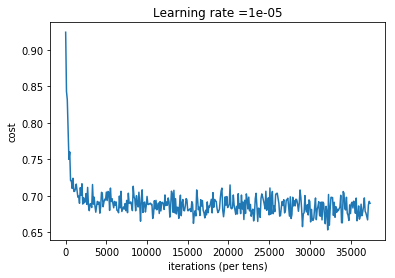

Average recall =1.0
Average recall =1.0


In [26]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#Train Network
total_step = len(train_loader)
epoch_list = []
loss_list = []
acc_list = []
total_recall = []
f1_total = []


best_val_acc = 0.0

for epoch in range(3):
    #logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs = inputs.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward propogation
        outputs = model(inputs)
        outputs = outputs.cuda()
        
        # calculate the loss
        loss = criterion(outputs, labels)
        
        # backpropogation + update parameters
        loss.backward()
        optimizer.step()

        # print statistics
        cost = loss.item()
        state = {'epoch': epoch + 1,
         'state_dict': model.state_dict(),
         'optim_dict' : optimizer.state_dict()}
        
        torch.save(model.state_dict(), '/home/ubuntu/CS230/CS230-Project/Model/result_densenet.pt')
        
#         utils.save_checkpoint({'epoch': epoch + 1,
#                                'state_dict': model.state_dict(),
#                                'optim_dict' : optimizer.state_dict()},
#                                is_best=is_best,
#                                checkpoint=model_dir)
        
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy() 
        
        recall = recall_score(labels,outputs, average = 'micro')
        total_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_total.append(f1)

        if i % 100 == 0:    # print every 1000 iterations
            print('Epoch:' + str(epoch) + ", Iteration: " + str(i) 
                  + ", training cost = " + str(cost) + ", Recall score =" + str(recall) 
                  + ", F1 score =" + str(f1))
            loss_list.append(cost)
            epoch_list.append(epoch*12500 + i)

plt.plot(epoch_list,loss_list)
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(lr))
plt.show()

print("Average recall =" + str(sum(total_recall)/len(total_recall)))
print("Average F1 score is: ",sum(f1_total)/len(f1_total))

In [28]:
print("Average F1 score is: ",sum(f1_total)/len(f1_total))

Average F1 score is:  0.26797749622088773


In [17]:

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from torch.autograd import Variable

def test():
    model = DenseNet121().cuda()
    model.load_state_dict(torch.load('/home/ubuntu/CS230/CS230-Project/Model/result_densenet.pt'))
    test_recall = []
    f1_test = []
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):

        
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())

        # Predict classes using images from the test set
        outputs = model(images)
        _, prediction = torch.max(outputs.data, 1)
        
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs[outputs >= 0.5] = 1
        outputs[outputs < 0.5] = 0
        labels = labels.cpu().detach().numpy()
        
        #test_acc += torch.sum(prediction == labels.data)
        
        recall = recall_score(labels,outputs, average = 'micro')
        test_recall.append(recall)
        
        f1 = f1_score(labels,outputs, average = 'micro')
        f1_test.append(f1)

    # Compute the average acc and loss over all 10000 test images
    #test_acc = test_acc / 10000
    
    print("Average recall =" + str(sum(test_recall)/len(test_recall)))
    print("Average F1 score is: ",sum(f1_test)/len(f1_test))

    return test_acc

In [18]:
test()

Average recall =1.0
Average F1 score is:  0.2521776151744316


0.0